# Q-learning notebook

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment import Environment
from agent import Qlearning, EpsilonGreedy
from plotting import (
    qtable_directions_map,
    plot_steps_and_rewards,
    plot_q_values_map,
    plot_rotated_q_values_map,
)

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=3, numEpisodes=100)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.05, n_runs=3, numEpisodes=100)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = Environment(params)

In [6]:
# State space
np.reshape(list(env.state_space), (env.rows, env.cols))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [7]:
# Load the agent algorithms
learner = Qlearning(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

## Main loop

In [8]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, *learner.qtable.shape))

for run in range(params.n_runs):  # Run several times to account for stochasticity
    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:

            action = explorer.choose_action(
                action_space=env.action_space, state=state, qtable=learner.qtable
            )

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.qtable[state, action] = learner.update(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.qtable

## Postprocessing

In [9]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(),
        "Steps": steps.flatten(),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [10]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,10.0,556.0,10.0
1,1,10.0,4166.0,10.0
2,2,10.0,387.0,10.0
3,3,0.0,15604.0,20.0
4,4,0.0,7365.0,20.0
...,...,...,...,...
295,95,0.0,6291.0,420.0
296,96,0.0,2585.0,430.0
297,97,10.0,1780.0,430.0
298,98,0.0,195.0,430.0


In [11]:
qtable_directions_map(qtable, env.rows, env.cols)

(array([[4.49817421e-04, 1.67117529e-01, 4.56557482e-04, 5.17947733e-04,
         5.42829006e-04],
        [1.67110078e-01, 4.51585741e-04, 4.63718856e-04, 3.94958569e-04,
         3.15083306e-04],
        [4.38758896e-04, 4.52715477e-04, 4.31917237e-04, 4.07017199e-04,
         1.47230900e-04],
        [4.19786405e-04, 5.05936542e-04, 3.91171018e-04, 1.85751564e-04,
         3.04620314e-05],
        [5.31058636e-04, 3.41567729e-04, 1.07111812e-04, 3.91435781e-05,
         0.00000000e+00]]),
 array([['←', '←', '→', '↓', '←'],
        ['↑', '↓', '→', '↑', '↑'],
        ['↓', '→', '←', '↑', '↑'],
        ['↑', '←', '↑', '↑', '↑'],
        ['↑', '↑', '↑', '↑', '']], dtype='<U1'))

## Visualization

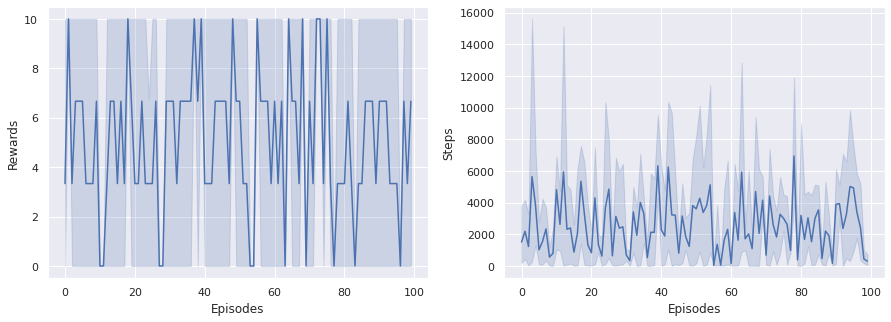

In [12]:
plot_steps_and_rewards(res)

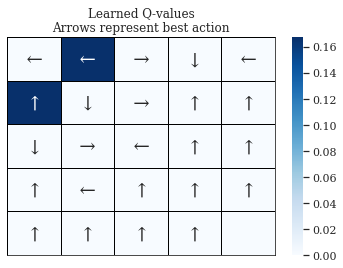

In [13]:
plot_q_values_map(qtable, env.rows, env.cols)

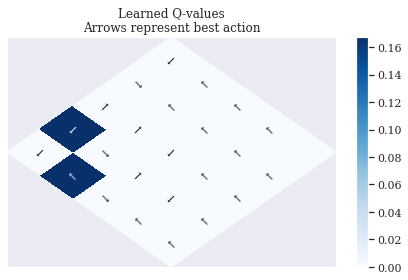

In [14]:
plot_rotated_q_values_map(qtable, env.rows, env.cols)